# BE Data Analysis - Thomas Bellier and Nathan Magnan
### Iris

In [1]:
import os #path handling
import numpy as np #import numpy drives sklearn to use numpy arrays instead of python lists
import pandas as pd #CSV and dataframe handling
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier #kNN classifier
from sklearn.svm import LinearSVC #linear classifier
from sklearn.neural_network import MLPClassifier #MLP classifier
from sklearn.model_selection import train_test_split #Data set splitting functions
from sklearn.metrics import confusion_matrix #Confusion matrix
#fixing the seed for all random actions
np.random.seed(1)

In [2]:
dataPath = './' # path to folder containing the Iris data
dataFile = os.path.join(dataPath,'iris.data') # data file to use

## 1 - Data import and formatting 

In [3]:
# we assign column names based on the description file. 'FType' stands for 'Flower Type'
fullDF = pd.read_csv(dataFile,header=None,names=['sepalL','sepalW','petalL','petalW','FType']) 
fullDF.sample(10) # let's take a random sample from the full data frame

,sepalL,sepalW,petalL,petalW,FType
14,5.8,4.0,1.2,0.2,Iris-setosa
98,5.1,2.5,3.0,1.1,Iris-versicolor
75,6.6,3.0,4.4,1.4,Iris-versicolor
16,5.4,3.9,1.3,0.4,Iris-setosa
131,7.9,3.8,6.4,2.0,Iris-virginica
56,6.3,3.3,4.7,1.6,Iris-versicolor
141,6.9,3.1,5.1,2.3,Iris-virginica
44,5.1,3.8,1.9,0.4,Iris-setosa
29,4.7,3.2,1.6,0.2,Iris-setosa
120,6.9,3.2,5.7,2.3,Iris-virginica


In [4]:
fullDF.describe() # quick statistical description of the dataframe

,sepalL,sepalW,petalL,petalW
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [5]:
# Let's define a mapping function from 'Flower type' to a class number
def dataMap(FType):
  """
  Data mapping function. Assigns a class number, given a class name
  Args:
    FType: (str) Flower type
  Returns: (int) Flower class
  """

  label = 0
  if FType == 'Iris-versicolor':
    label = 0
  elif FType == 'Iris-setosa':
    label = 1
  elif FType == 'Iris-virginica':
    label = 2
  else:
    raise(RuntimeWarning(f'Unknown flower type: {FType}, using default label 0'))
  
  return label

In [6]:
# Let's apply the mapping function to the input data and create a new column called 'Y'
fullDF['Y'] = [dataMap(item) for item in fullDF['FType']]

In [7]:
# Let's check that mapping works on a few random samples
fullDF.sample(10)

,sepalL,sepalW,petalL,petalW,FType,Y
132,6.4,2.8,5.6,2.2,Iris-virginica,2
1,4.9,3.0,1.4,0.2,Iris-setosa,1
114,5.8,2.8,5.1,2.4,Iris-virginica,2
62,6.0,2.2,4.0,1.0,Iris-versicolor,0
110,6.5,3.2,5.1,2.0,Iris-virginica,2
27,5.2,3.5,1.5,0.2,Iris-setosa,1
91,6.1,3.0,4.6,1.4,Iris-versicolor,0
36,5.5,3.5,1.3,0.2,Iris-setosa,1
85,6.0,3.4,4.5,1.6,Iris-versicolor,0
98,5.1,2.5,3.0,1.1,Iris-versicolor,0


In [8]:
# Separate data from classes
dataDF = fullDF[['sepalL','sepalW','petalL','petalW']]
classDF = fullDF['Y']

## 2 - Data splitting 

In [9]:
# Let's split the data into training data, and test data. Same splitting should be applied to classes.
# Here, the test data size is 10% of the full dataset
trainData,testData,trainY,testY = train_test_split(dataDF,classDF,test_size=0.1)

## 3 - kNN 

Comme c'est la première fois qu'on l'utilise, on rapelle l'idée générale de la méthode des $k$-Nearest-Neighbors : Pour une observation $\underline{X}$, on regarde la classe des $k$ points d'entrainement les plus proches, et on choisi la classe majoritaire [1]. C'est un classifieur souvent performant pour les problèmes déterministes, sur lesquels on n'attends pas d'effets aléatoires [2].

L'utilisateur doit choisir la norme utilisée pour trouver les "plus proches voisins", et le nombre $k$. Ici, on fait le choix classique de $k = 3$ et de la norme euclidienne. C'est souvent une norme performante pour les problèmes où toutes les features évoluent dans une espace continu [2].

Au vu de cette description, on pourrait s'étonner de la ligne $\textit{kNN.fit()}$ qui suit. Mais pour accélérer les appels futurs au classifieur, on construit dès maintenant un $k$D tree pour le training set. Ainsi il sera très rapide pour le classifieur (maintenant muni de son arbre de recherche) de trouver les $k$ voisins d'un point quelconque. C'est le calcul de cette arbre que contient l'étape $\textit{fit}$ (ce n'est donc pas du fitting à proporement parler).

Notons que l'on aurait aussi pu optimiser la valeur de $k$, et les échelles des différentes features dans la norme euclidienne.

In [10]:
# Let's build a kd Tree out of our training data and use euclidian distance as a metric.
# This can be replaced by a custom metric
kNN = KNeighborsClassifier(n_neighbors=3,algorithm='kd_tree',metric='minkowski',p=2,n_jobs=-1)
kNN.fit(trainData,trainY)

KNeighborsClassifier(algorithm='kd_tree', n_jobs=-1, n_neighbors=3)

In [11]:
# Check the classifier's performance on the training data
trainPredictions = kNN.predict(trainData)
trainCM = confusion_matrix(y_pred=trainPredictions,y_true=trainY)
print(trainCM)

[[45  0  3]
 [ 0 41  0]
 [ 2  0 44]]


On voit ici que le classifieur $k$NN ne fait pas des prédictions parfaites, même sur les points d'entrainements. On apprends ainsi 2 choses :

-  D'une part, on peut être (raisonnablement) confiant que l'on aura pas d'overfitting, car on a déjà pas saturé le fitting sur les points d'entrainement. En fait, comme il n'y as pas d'hyperparamètres dans la méthode $k$NN, il n'y jamais de risque d'overfitting. Sauf si l'on fait des __weighthed__ $k$NN [2].

-  D'autre part, on a des infos sur la géométrie de l'espace des features : il y a des _iris versicolor_ dans l'envellope convexe des _iris virginica_ , et inversement. Mais sans doute qu'un critère supplémentaire (la couleur, par exemple) aurait beaucoup plus séparé les 2 groupes.

## 4 - kNN classifier performance 

In [12]:
# Check the classifier's performance on the test data
predictions = kNN.predict(testData)
testCM = confusion_matrix(y_pred=predictions,y_true=testY)
print(testCM)

[[2 0 0]
 [0 9 0]
 [1 0 3]]


Sur les 15 points de test, le classificateur $k$NN ne fait qu'une erreur (93 % de précision). Certes la statistique sur 15 points est contestable, mais ce résultat reste satisfaisant !

Comme dit plus haut, le classifieur $k$NN standard n'a pas d'hyperparamètre. Donc si les données d'entrainement et de test ont la même origine, ce classifieur sera toujours aussi performants sur les données de test et d'entrainement (dit autrement : il n'a pas réellement été entrainé).

Enfin, on remarque à nouveau que l'erreur est entre les _iris versicolor_ et les _iris virginica_ , car ces 2 groupes se recouvrent géométriquement dans l'espace des paramètres.

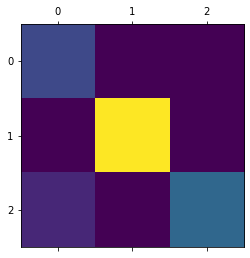

In [13]:
# You can also plot the confusion matrix
plt.matshow(testCM)

Ici, on a que 3 classes donc la visualisation n'aide pas tant que ça. Mais pour des problèmes plus complèxes avec des centaines des classes, l'oeil humain est dépassé par la forme mathématique, et une image lui convient beaucoup mieux.

## 5 - Linear classification

Comme c'est la première fois qu'on l'utilise, on rapelle l'idée générale du classifieur linéaire. C'est un classifieur donc la force réside dans la simplicité (et donc la vitesse).

C'est à nouveau un classifieur très géométrique. Si l'on avait que 2 classes, l'idée serait de trouver un hyperplan de l'espace des features qui sépare les 2 groupes. Pour chaque nouvelle observation, on regarde si elle est _en dessous_ ou _au dessus_ de l'hyperplan, et on la classifie en fonction [3].

Ici, on a 3 classes, donc c'est légérement plus complexe : on va devoir trouver 3 hyperplans. Le premier sépare la première classe des deux autres, le seconde sépare la seconde classe, et le troisième la troisième classe [1]. La classification est alors facile pour une observation qui est _en dessous_ d'un seul des hyperplan.

Pour ce classifieur-ci, il y a un vrai entrainement : la recherche des hyperplans (ou plutôt, de vecteurs normaux aux hyperplans). Mais comme il y a peu d'hyperparamètres, le risque d'overfitting reste faible.

In [14]:
# Let's build a linear classifier out of our training data and use euclidian distance as a metric.
# This can be replaced by a custom metric
classifier = LinearSVC(max_iter=1e5)
classifier.fit(trainData,trainY)

LinearSVC(max_iter=100000.0)

In [15]:
# Check the classifier's performance on the training data
trainPredictions = classifier.predict(trainData)
trainCM = confusion_matrix(y_pred=trainPredictions,y_true=trainY)
print(trainCM)

[[45  0  3]
 [ 0 41  0]
 [ 2  0 44]]


Les résultats sont identiques au classifieur $k$NN. On pense que les résultats sont identiques uniquement pour ce data set particulier, mais qu'en revanche on peut généraliser l'idée que la qualité des résultats est simillaire à tout les problèmes de ce genre. 

On confirme ensuite que les _iris versicolor_ et les _iris virginica_ vont être durs à séparer sur des critères purements géométriques (et ces 4 seuls critères).

Et comme les prédictions ne sont pas parfaites sur les points d'entrainement, on peut s'attendre à ne pas voir d'overfitting. On s'y attend aussi à partir du ratio hyperparamètres sur points d'entrainement : on avait 12 hyperparamètres pour 135 points d'entraînement.

## 6 - Linear classifier performance 

In [16]:
# Check the classifier's performance on the test data
predictions = classifier.predict(testData)
testCM = confusion_matrix(y_pred=predictions,y_true=testY)
print(testCM)

[[2 0 0]
 [0 9 0]
 [1 0 3]]


Pour les points de test aussi, le résultat est identique à celui du classifieur $k$NN. C'était attendu, car la qualité des prédictions était la même sur les points d'entrainement, donc en l'absence d'overfitting elle doit aussi être la même sur des points de test (sous l'hypothèse que les points de test ont la même origine que les points d'entrainement). 

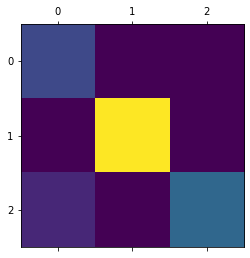

In [17]:
# You can also plot the confusion matrix
plt.matshow(testCM)

## 7 - MLP classification

Comme c'est la première fois qu'on l'utilise, on rapelle l'idée générale du classifieur MLP (Multi-Layer Perceptron). Cette fois-ci, c'est un classifieur très abstrait, sans intéprétation simple.

Il s'agit d'un résaeu de neurones à 3 niveaux [4]. Les neurones du premier niveau (_input layer_ ) s'activent ou non selon les valeurs des features de l'observation. Ensuite, les neurones du second niveau (_hidden layer_ ) s'activent ou non selon l'état d'activation des neurones du premier niveau. Enfin, les neurones du dernier niveau (_output layer_ ) s'activent ou non selon l'état d'activation du second niveau [1].

L'entrainement consiste à optimiser les fonctions qui servent à choisir si un neurone s'active ou non, en fonction des activations du niveau précédent. Pour cela, on fait de l'inférence bayésienne : on commence par une valeur arbitraire de tous les coefficients internes aux fonctions. Puis on fait une prediction pour les points d'entrainement, que l'on compare à la correction. Cette prédiction est mauvaise, mais l'erreur nous permet de corriger les coefficients. On recommence alors le processus avec les nouveaux coefficients. <br>
Ce processus itératif est lent, mais finit (si tout se passe bien) par converger vers la valeur optimale des coefficients, c'est à dire celle qui minimise l'erreur de prédiction moyenne sur les données d'entrainement. 

L'avantage de ce classifieur est sa généralité, il est performant sur une large classe de problèmes, même très complexes [4]. En revanche, la phase d'optimisation est lente, et s'il on a mis trop de neurones dans le _hidden layer_ , il y a un fort risque d'overfitting.

In [18]:
# Let's build a linear classifier out of our training data and use euclidian distance as a metric.
# This can be replaced by a custom metric
mlp = MLPClassifier(solver='lbfgs', activation='logistic', max_iter=1e3)
mlp.fit(trainData,trainY)

MLPClassifier(activation='logistic', max_iter=1000.0, solver='lbfgs')

In [19]:
# Check the classifier's performance on the training data
trainPredictions = mlp.predict(trainData)
trainCM = confusion_matrix(y_pred=trainPredictions,y_true=trainY)
print(trainCM)

[[48  0  0]
 [ 0 41  0]
 [ 0  0 46]]


On voit ici que les prédictions sur les points d'entrainement sont parfaites. D'un coté, cela signifie que l'on a outrepassé notre problème de géométrie entre les _iris versicolor_ et  les _iris virginica_ . 

Par contre, c'est inquiétant vis-a-vis du risque d'overfitting : une erreur nulle est possible pour notre petit training set. Le classifieur a arrété son entrainement sur un point d'erreur nulle, mais ce point n'est qu'une solution parmi d'autres (sans doute très nombreuses). Il faudrait plus de points d'entrainement pour savoir laquelle de ces solutions explique le mieux la réalité (par opposition à l'explication de nos données finies).

On peut se réprésenter l'overfitting avec le problème d'interpolation de Lagrange : si je veux expliquer $n$ point par un polynôme, il me suffit d'un polynôme de degrès $n - 1$ (et il est unique). Et si je prends un polynôme de degrés supérieur, j'ai aussi plein de solutions mais elles seront en fort désaccord en dehors des $n$ points d'entrainement. Ainsi, je suis capable de faire une prédiction si je me place dans $\mathbb{R}_{n}[X]$, mais pas si je me place dans $\mathbb{R}_{n+1}[X]$ : j'ai trop d'hyperparamètres.

## 8 - MLP classifier performance 

In [20]:
# Check the classifier's performance on the test data
predictions = mlp.predict(testData)
testCM = confusion_matrix(y_pred=predictions,y_true=testY)
print(testCM)

[[2 0 0]
 [0 9 0]
 [1 0 3]]


Mais finalement, notre classifieur MLP atteint d'aussi bons résultats que les précédents classifieurs. Il semble qu'il n'y ait pas eu d'overfitting ici. Quoique 15 tests ne forment pas une statistique suffisante pour être formel.

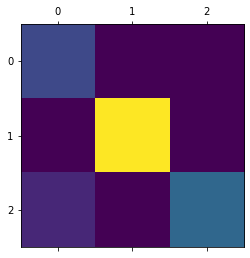

In [21]:
# You can also plot the confusion matrix
plt.matshow(testCM)

## Références

[1] Notes de cours

[2] Page Wikipedia sur le classifieur $k$NN : https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm

[3] Page Wikiepdia sur la classification linéaire : https://en.wikipedia.org/wiki/Linear_classifier

[4] Page WIkiepdia sur le classifieur MLP : https://en.wikipedia.org/wiki/Multilayer_perceptron